# Домашнее задание: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [3]:
def binary_cross_entropy(k1: int,
                         k2: int) -> np.float32:
    prob1 = k1 / (k1+k2)
    prob2 = k2 / (k1+k2)
    return np.round(-prob1 * np.log(prob1) - prob2 * np.log(prob2), 2)

binary_cross_entropy(8, 2)

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
def gini(samples: np.array) -> np.float32:
    probs = samples / np.sum(samples)
    probs_neg = 1 - probs
    return np.sum(probs * probs_neg)

def information_criteria(samples: np.array) -> np.float32:
    criteria_m = gini(samples)
    criteria_left = gini(np.array([samples[0], 0]))
    criteria_right = gini(np.array([0, samples[1]]))
    return criteria_m - samples[0] / np.sum(samples) * criteria_left - samples[1] / np.sum(samples) * criteria_right

information_criteria(np.array([8, 2]))

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
def predict_node(values: np.array) -> np.float32:
    return np.mean(values)

predict_node([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [8]:
import numpy as np
import pandas as pd
from typing import Union, Tuple, List, Any 

def _gini_impurity(target_vector: np.ndarray) -> float:
    """
    Calculates Gini impurity for a target vector.
    Gini(R) = 1 - sum(p_k^2)
    """
    if target_vector.size == 0:
        return 0.0
    # np.unique also sorts the unique values
    _, counts = np.unique(target_vector, return_counts=True)
    probabilities = counts / target_vector.size
    return 1 - np.sum(probabilities**2)

def _variance(target_vector: np.ndarray) -> float:
    """
    Calculates variance for a target vector.
    Var(R) = E[(X - E[X])^2]
    """
    if target_vector.size == 0:
        return 0.0
    return np.var(target_vector)

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame, pd.Series], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, Any, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака (для 'real' типа).
    * Поведение функции в случае константного признака может быть любым (здесь возвращаем пустые массивы и NaN/-inf).
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит (минимальное значение порога).
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :) (Цикл по категориальным признакам оставлен, 
      так как его векторизация без предположений о природе категорий сложна. Цикл по порогам для real признаков векторизован).

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами
    :return gains: вектор со значениями критерия информативности (Information Gain) для каждого из порогов
    :return threshold_best: оптимальный порог (число или значение категории)
    :return gain_best: оптимальное значение критерия информативности
    """
    feature_vector = np.asarray(feature_vector).flatten()
    target_vector = np.asarray(target_vector).flatten()
    n_samples = len(feature_vector)
    if n_samples <= 1 or len(target_vector) != n_samples:
        return np.array([]), np.array([]), np.nan, -np.inf

    if task == "classification":
        impurity_func = _gini_impurity
    elif task == "regression":
        impurity_func = _variance
    else:
        raise ValueError("Task must be 'classification' or 'regression'")
    
    parent_impurity = impurity_func(target_vector)
    best_gain = -np.inf
    best_threshold: Any = np.nan 
    if feature_type == "real":
        sorted_indices = np.argsort(feature_vector)
        sorted_features = feature_vector[sorted_indices]
        sorted_targets = target_vector[sorted_indices]
        diff_indices = np.where(np.diff(sorted_features) != 0)[0]
        if len(diff_indices) == 0:
            return np.array([]), np.array([]), np.nan, -np.inf
        reportable_thresholds = (sorted_features[diff_indices] + sorted_features[diff_indices + 1]) / 2.0
        N_l_vec = diff_indices + 1
        N_r_vec = n_samples - N_l_vec
        gains_at_thresholds = np.full(len(reportable_thresholds), -np.inf, dtype=float)

        if task == "classification":
            unique_classes_in_subset, mapped_sorted_targets = np.unique(sorted_targets, return_inverse=True)
            if len(unique_classes_in_subset) <= 1:
                gains_at_thresholds = np.zeros(len(reportable_thresholds))
            else:
                target_one_hot_sorted = np.eye(len(unique_classes_in_subset))[mapped_sorted_targets]
                cumsum_one_hot = np.cumsum(target_one_hot_sorted, axis=0)
                left_counts = cumsum_one_hot[diff_indices, :]
                total_counts_all_classes = cumsum_one_hot[n_samples - 1, :] 
                right_counts = total_counts_all_classes - left_counts
                p_left = left_counts / N_l_vec[:, None]
                gini_left = 1 - np.sum(p_left**2, axis=1)
                p_right = right_counts / N_r_vec[:, None]
                gini_right = 1 - np.sum(p_right**2, axis=1)
                gains_at_thresholds = parent_impurity - (N_l_vec / n_samples * gini_left + N_r_vec / n_samples * gini_right)

        elif task == "regression":
            cumsum_targets = np.cumsum(sorted_targets)
            cumsum_targets_sq = np.cumsum(sorted_targets**2)
            sum_y_left = cumsum_targets[diff_indices]
            sum_y_sq_left = cumsum_targets_sq[diff_indices]
            var_left = (sum_y_sq_left / N_l_vec) - (sum_y_left / N_l_vec)**2
            sum_y_total = cumsum_targets[n_samples - 1]
            sum_y_sq_total = cumsum_targets_sq[n_samples - 1]
            sum_y_right = sum_y_total - sum_y_left
            sum_y_sq_right = sum_y_sq_total - sum_y_sq_left
            var_right = (sum_y_sq_right / N_r_vec) - (sum_y_right / N_r_vec)**2  
            gains_at_thresholds = parent_impurity - (N_l_vec / n_samples * var_left + N_r_vec / n_samples * var_right)
        all_thresholds_np = reportable_thresholds
        all_gains_np = gains_at_thresholds

        if len(all_gains_np) > 0 : 
            if np.all(np.isneginf(all_gains_np)):
                 best_gain = -np.inf
                 best_threshold = np.nan 
            else:
                best_idx = np.argmax(all_gains_np)
                best_gain = all_gains_np[best_idx]
                best_threshold = all_thresholds_np[best_idx]
        
        return all_thresholds_np, all_gains_np, best_threshold, best_gain

    elif feature_type == "categorical":
        unique_categories = np.unique(feature_vector)
        if len(unique_categories) <= 1:
            return np.array([]), np.array([]), np.nan, -np.inf
        all_thresholds_list: List[Any] = []
        all_gains_list: List[float] = []
        for cat_val in unique_categories:
            left_mask = (feature_vector == cat_val)
            right_mask = (feature_vector != cat_val)
            targets_left = target_vector[left_mask]
            targets_right = target_vector[right_mask]
            if targets_left.size == 0 or targets_right.size == 0:
                continue 
            n_l = targets_left.size
            n_r = targets_right.size
            impurity_left = impurity_func(targets_left)
            impurity_right = impurity_func(targets_right)
            current_gain = parent_impurity - (n_l / n_samples * impurity_left + n_r / n_samples * impurity_right)
            all_thresholds_list.append(cat_val) 
            all_gains_list.append(current_gain)

        if not all_thresholds_list:
             return np.array([]), np.array([]), np.nan, -np.inf

        all_thresholds_np = np.array(all_thresholds_list)
        all_gains_np = np.array(all_gains_list)
        try:
            sort_indices = np.argsort(all_thresholds_np)
            all_thresholds_sorted = all_thresholds_np[sort_indices]
            all_gains_sorted = all_gains_np[sort_indices]
        except TypeError: 
            all_thresholds_sorted = all_thresholds_np 
            all_gains_sorted = all_gains_np

        if len(all_gains_sorted) > 0:
            best_idx = np.argmax(all_gains_sorted)
            best_gain = all_gains_sorted[best_idx]
            best_threshold = all_thresholds_sorted[best_idx]
        return all_thresholds_sorted, all_gains_sorted, best_threshold, best_gain
    else:
        raise ValueError("feature_type must be 'real' or 'categorical'")

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

Установим версию sklearn, которая содержит датасет Boston

In [8]:
!pip3 install scikit-learn==1.0.2

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 23.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [9]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]
X.head()

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/home/kirill/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dat

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

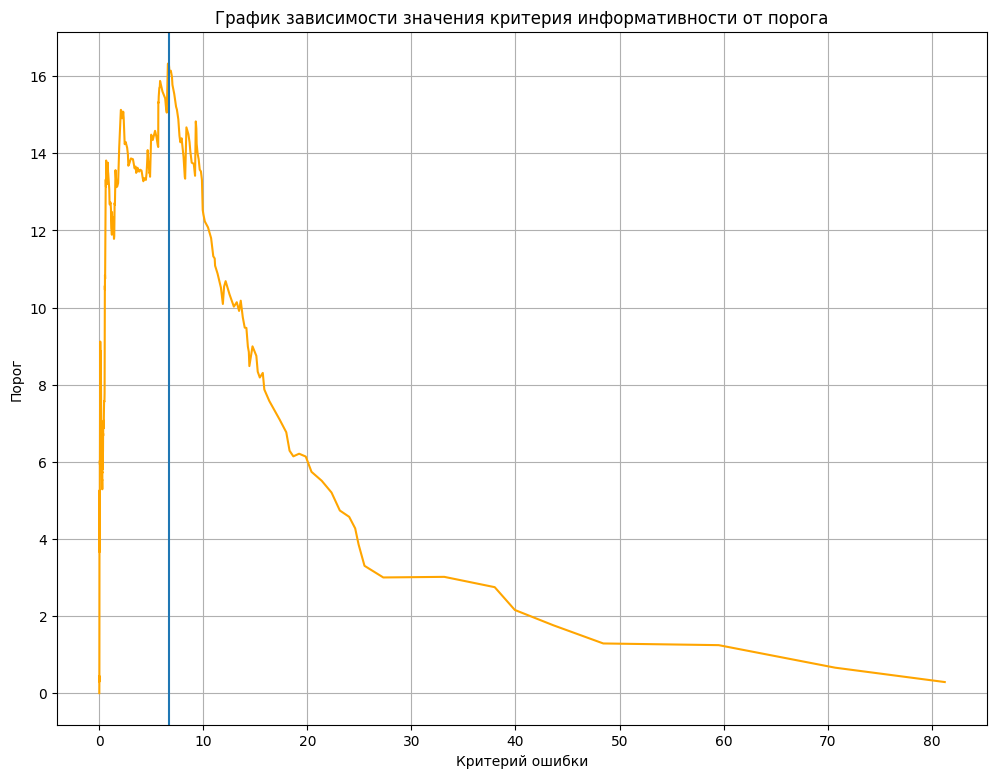

In [10]:
all_thresholds, all_gains_sorted, best_threshold, best_gain = find_best_split(X['CRIM'].to_numpy(),
                                                                              y,
                                                                              task='regression',
                                                                              feature_type='real')

fig, ax = plt.subplots(figsize=(12, 9))
ax.grid()
ax.set_title('График зависимости значения критерия информативности от порога')
ax.set_xlabel('Критерий ошибки')
ax.set_ylabel('Порог')
ax.plot(all_thresholds, all_gains_sorted, color='orange')
ax.axvline(best_threshold)

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [11]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        feature = node['feature_split']
        type = self._feature_types[node['feature_split']]
        if type == 'categorical':
            if x[feature] == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        elif type == 'real':
            if x[feature] < node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [12]:
data = pd.read_csv('students.csv')
data = data.drop(columns='Unnamed: 0')
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


Text(0, 0.5, 'Значение критерия Джини')

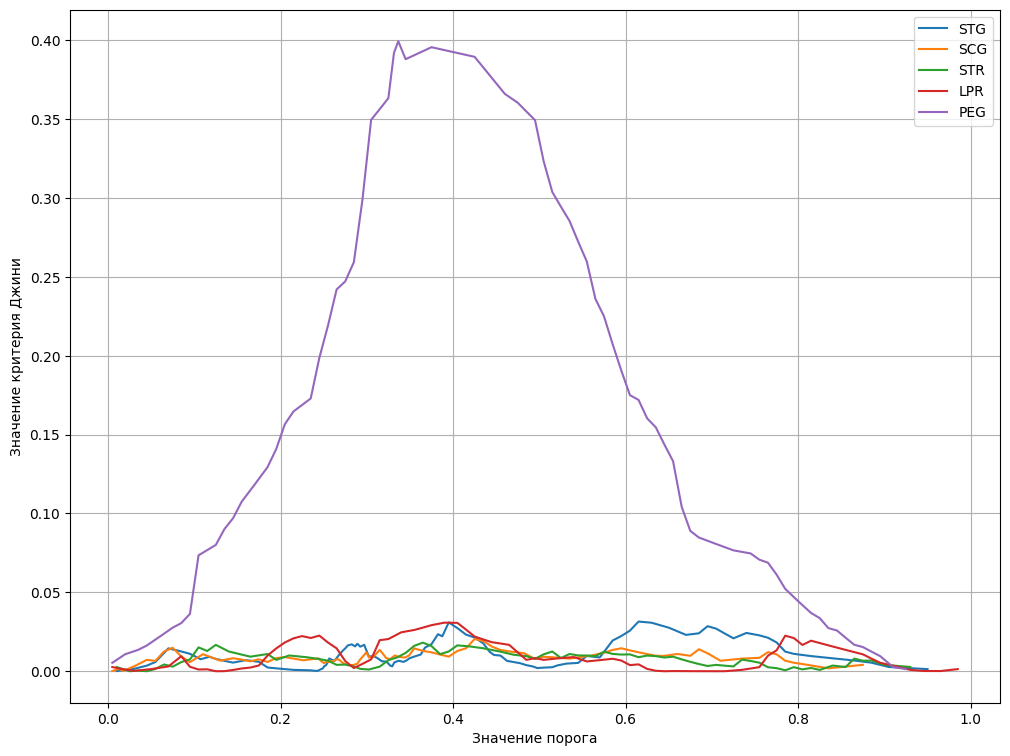

In [13]:
fig, ax = plt.subplots(figsize=(12, 9))

X = data.drop(columns='UNS')
y = data['UNS']
for col in list(X.columns):
    all_thresholds, all_gains_sorted, best_threshold, best_gain = find_best_split(X[col].to_numpy(),
                                                                                  y.to_numpy(),
                                                                                  task='classification',
                                                                                  feature_type='real')
    ax.plot(all_thresholds, all_gains_sorted, label=col)

ax.legend()
ax.grid()
ax.set_xlabel('Значение порога')
ax.set_ylabel('Значение критерия Джини')

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

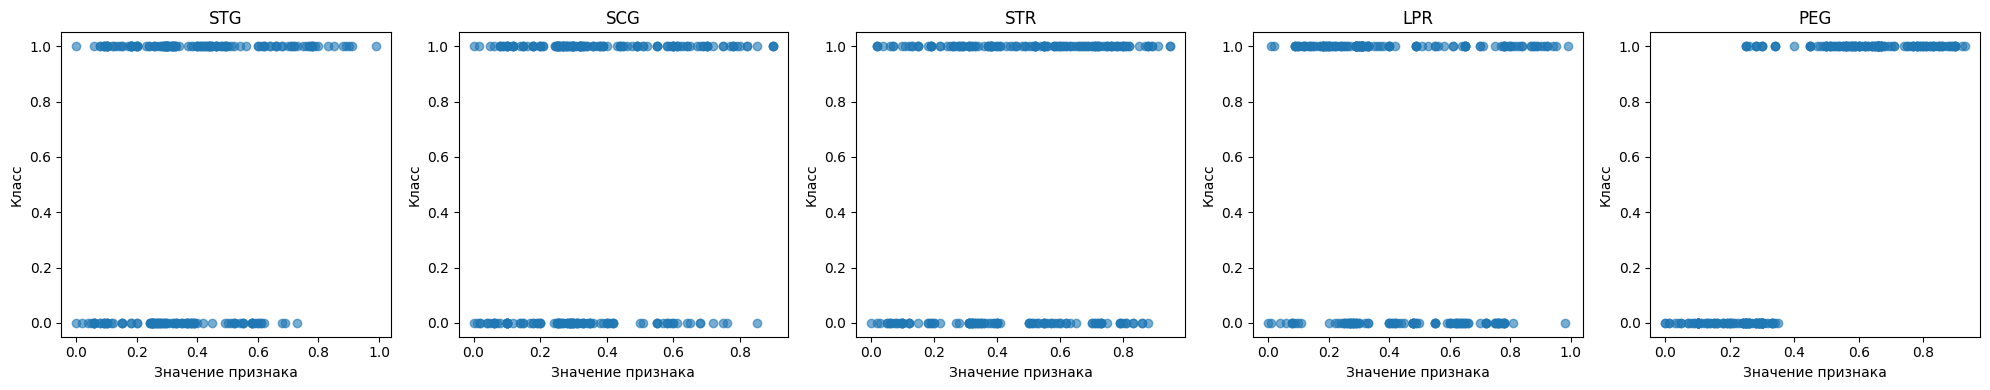

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(list(X.columns)):
    axes[i].scatter(X[col], y, alpha=0.6)
    axes[i].set_title(col)
    axes[i].set_xlabel("Значение признака")
    axes[i].set_ylabel("Класс")
plt.tight_layout()
plt.show()

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [19]:

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = ["class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment",
           "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root",
           "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring",
           "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
           "spore-print-color", "population", "habitat"]
data = pd.read_csv(url, header=None, names=columns)
data.head()


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

enc = LabelEncoder()
for col in data.columns:
    data[col] = enc.fit_transform(data[col])

X = data.drop(columns='class')
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


In [21]:
model = DecisionTree(feature_types=['categorical'] * X.shape[1],
                     task='classification')

In [22]:
model.fit(X_train.to_numpy(), y_train.to_numpy())
y_preds = model.predict(X_test.to_numpy())

In [23]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_preds)

0.9992614475627769

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [24]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [25]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

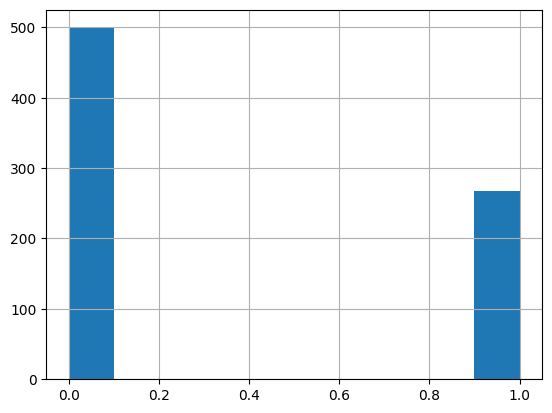

In [26]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [27]:
X = data.drop(columns='Outcome')
y = data.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [28]:
import optuna
from sklearn.metrics import f1_score
from optuna.samplers import TPESampler

/home/kirill/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 500),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
    }
    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    return f1_score(y_val, preds)

study = optuna.create_study(direction='maximize', 
                            sampler=TPESampler())
study.optimize(objective, n_trials=1000)

[I 2025-05-30 00:34:01,828] A new study created in memory with name: no-name-f8d581f8-f21d-4f30-bbe6-3a5072f5e1a4
[I 2025-05-30 00:34:01,850] Trial 0 finished with value: 0.4791666666666667 and parameters: {'max_depth': 353, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.4791666666666667.
[I 2025-05-30 00:34:01,866] Trial 1 finished with value: 0.5333333333333333 and parameters: {'max_depth': 306, 'min_samples_leaf': 13}. Best is trial 1 with value: 0.5333333333333333.
[I 2025-05-30 00:34:01,882] Trial 2 finished with value: 0.4545454545454546 and parameters: {'max_depth': 324, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.5333333333333333.
[I 2025-05-30 00:34:01,893] Trial 3 finished with value: 0.4791666666666667 and parameters: {'max_depth': 400, 'min_samples_leaf': 15}. Best is trial 1 with value: 0.5333333333333333.
[I 2025-05-30 00:34:01,907] Trial 4 finished with value: 0.5242718446601942 and parameters: {'max_depth': 184, 'min_samples_leaf': 11}. Best is trial 1

In [32]:
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

In [33]:
best_params = study.best_params
final_model = DecisionTreeClassifier(**best_params)
final_model.fit(X_full, y_full)

DecisionTreeClassifier(max_depth=14, min_samples_leaf=3)

In [34]:
from sklearn.metrics import (precision_score, recall_score, roc_auc_score)
preds = final_model.predict(X_test)
probas = final_model.predict_proba(X_test)[:, 1]
(   
    accuracy_score(y_test, preds),
    precision_score(y_test, preds),
    recall_score(y_test, preds),
    roc_auc_score(y_test, probas)
)

(0.70995670995671, 0.581081081081081, 0.5443037974683544, 0.7120253164556962)

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [35]:
model = BaggingClassifier(n_estimators=50)
model.fit(X_full, y_full)
preds = model.predict(X_test)
probas = model.predict_proba(X_test)[:, 1]
(   
    accuracy_score(y_test, preds),
    precision_score(y_test, preds),
    recall_score(y_test, preds),
    roc_auc_score(y_test, probas)
)

(0.8138528138528138,
 0.7195121951219512,
 0.7468354430379747,
 0.8519320453031312)

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [36]:
from sklearn.model_selection import cross_val_score

In [37]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 500),
        'min_samples_split': trial.suggest_int('min_samples_split', 1, 10)
    }
    model = RandomForestClassifier(n_estimators=50, **params)
    return np.mean(cross_val_score(model, X_full, y_full, scoring='f1'))

study = optuna.create_study(direction='maximize', 
                            sampler=TPESampler())
study.optimize(objective, n_trials=500)

[I 2025-05-30 00:35:20,188] A new study created in memory with name: no-name-786c5627-3ac3-4466-b696-6a295146fb5c
[I 2025-05-30 00:35:20,848] Trial 0 finished with value: 0.6240266428239731 and parameters: {'max_depth': 149, 'min_samples_split': 8}. Best is trial 0 with value: 0.6240266428239731.
[I 2025-05-30 00:35:21,569] Trial 1 finished with value: 0.6081340452218084 and parameters: {'max_depth': 473, 'min_samples_split': 7}. Best is trial 0 with value: 0.6240266428239731.
[I 2025-05-30 00:35:22,295] Trial 2 finished with value: 0.5849344608228207 and parameters: {'max_depth': 441, 'min_samples_split': 6}. Best is trial 0 with value: 0.6240266428239731.
[I 2025-05-30 00:35:23,029] Trial 3 finished with value: 0.616483157965612 and parameters: {'max_depth': 108, 'min_samples_split': 7}. Best is trial 0 with value: 0.6240266428239731.
[I 2025-05-30 00:35:23,596] Trial 4 finished with value: 0.5833333333333334 and parameters: {'max_depth': 48, 'min_samples_split': 5}. Best is trial 0 

In [38]:
best_params = study.best_params
final_model = RandomForestClassifier(n_estimators=50, **best_params)
final_model.fit(X_full, y_full)

RandomForestClassifier(max_depth=327, min_samples_split=7, n_estimators=50)

In [39]:
preds = final_model.predict(X_test)
probas = final_model.predict_proba(X_test)[:, 1]
(   
    accuracy_score(y_test, preds),
    precision_score(y_test, preds),
    recall_score(y_test, preds),
    roc_auc_score(y_test, probas)
)

(0.7748917748917749, 0.684931506849315, 0.6329113924050633, 0.8557628247834776)

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

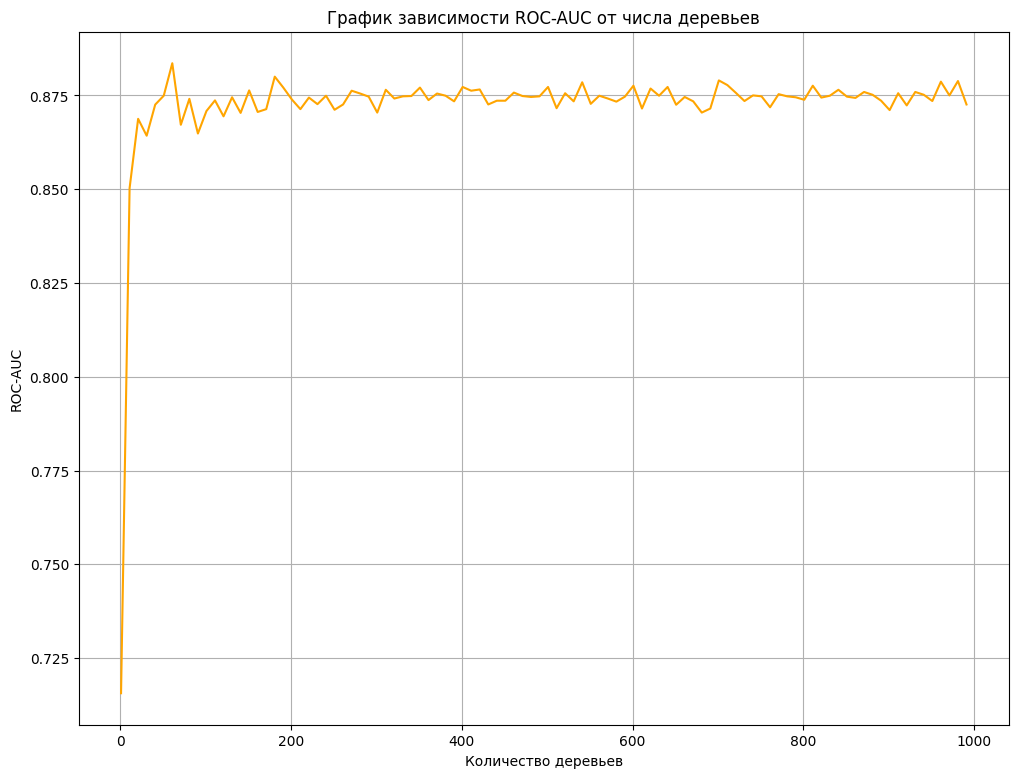

In [41]:
n_grid = np.arange(1, 1000, 10)
auc_scores = []
for n in n_grid:
    model = RandomForestClassifier(n_estimators=n, **best_params)
    model.fit(X_full, y_full)
    probas = model.predict_proba(X_test)[:, 1]
    auc_scores.append(roc_auc_score(y_test, probas))

fig, ax = plt.subplots(figsize=(12, 9))
ax.grid()
ax.set_title('График зависимости ROC-AUC от числа деревьев')
ax.set_xlabel('Количество деревьев')
ax.set_ylabel('ROC-AUC')
ax.plot(n_grid, auc_scores, color='orange')

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Pregnancies'),
  Text(1, 0, 'Glucose'),
  Text(2, 0, 'BloodPressure'),
  Text(3, 0, 'SkinThickness'),
  Text(4, 0, 'Insulin'),
  Text(5, 0, 'BMI'),
  Text(6, 0, 'DiabetesPedigreeFunction'),
  Text(7, 0, 'Age')])

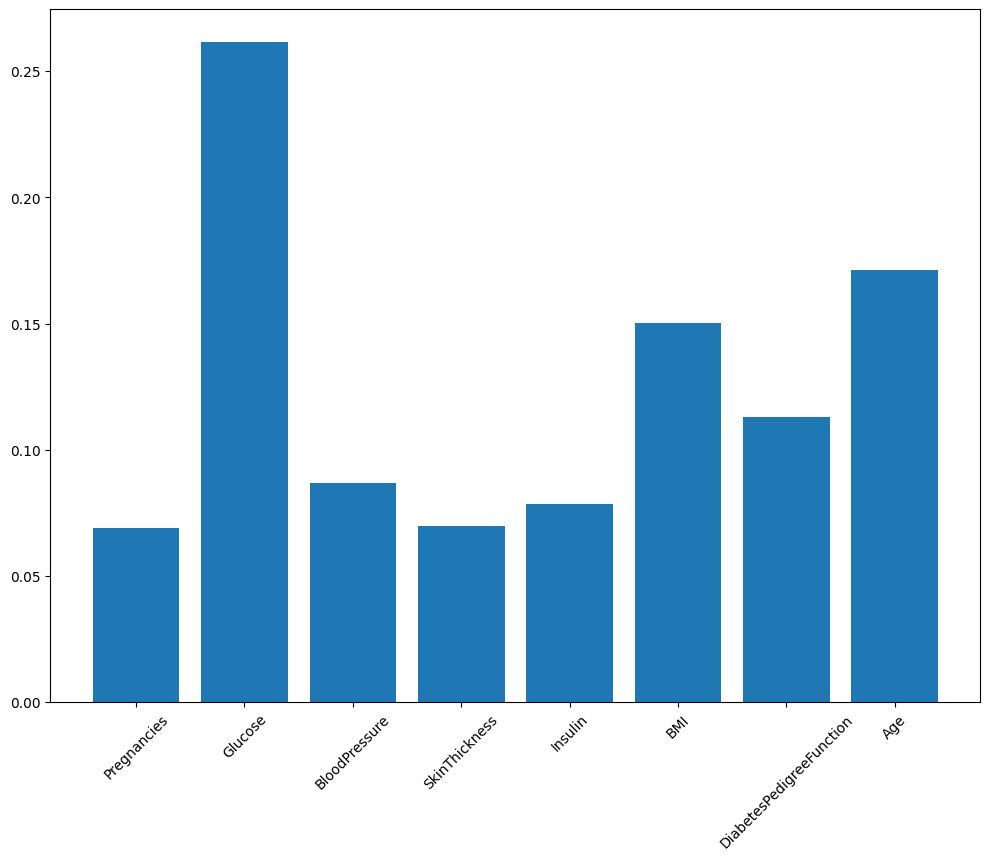

In [52]:
fig, ax = plt.subplots(figsize=(12, 9))
ax.bar(list(X.columns), final_model.feature_importances_)
plt.xticks(rotation=45)